In [1]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter, BCS, solve_time_evolution, calculate_bohmgrybohm_from_jardin, calculate_bohmdiffusion, calculate_elm_frequency_from_normalised_alpha

import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

In [2]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83628
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)
N_POINTS = 1000
R        = np.linspace(machineparams.Rmaj, machineparams.Rmaj + machineparams.Rmin, N_POINTS)
phi      = R**2
phi_norm = (phi - phi.min()) / (phi.max() - phi.min())
pedestal_region =  phi_norm > 0.8
phi_norm = phi_norm[pedestal_region]
phi      = phi[pedestal_region]
R        = R[pedestal_region]

steady_state_te = mtanh(phi_norm, te_fit_params.h1, te_fit_params.h0, te_fit_params.s, te_fit_params.w, te_fit_params.p)
steady_state_ne = mtanh(phi_norm, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, ne_fit_params.w, ne_fit_params.p)
steady_state_pe = mtanh(phi_norm, pe_fit_params.h1, pe_fit_params.h0, pe_fit_params.s, pe_fit_params.w, pe_fit_params.p)
steady_state_pe_from_me = calculate_pressure(steady_state_te, steady_state_ne)

tped_idx = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
nped_idx = np.argmin(np.abs(phi_norm - (ne_fit_params.p - ne_fit_params.w)))

In [4]:
chi_gb, gyroradius = calculate_bohmgrybohm_from_jardin(R, phi, phi_norm, steady_state_te, machineparams)
Dbohm = calculate_bohmdiffusion(steady_state_te, machineparams) / 100.0

In [44]:
CHI0 = chi_gb[0]
C_CRASH    = 3.5
D0_INTRA   = 25.0

INTRA_PARAMS = TransParams(
    CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w, C_CRASH, CHI0), # np.ones_like(phi_norm),
    D=normal_distribution(phi_norm, ne_fit_params.p, ne_fit_params.w / 2.0, C_CRASH, D0_INTRA), # np.ones_like(phi_norm),
    V=np.ones_like(phi_norm),
    S_N=np.zeros_like(phi_norm),
    S_T=np.zeros_like(phi_norm),
    _C = C_CRASH,
    ne_fitparams=ne_fit_params, 
    te_fitparams=te_fit_params, 
    bcs=BCS.INTRA_FLUXIN
)


C_INTER = 10.0
INTER_PARAMS = TransParams(
        CHI = np.empty_like(phi_norm),
        D   = np.empty_like(phi_norm),
        V   = phi_norm**5,
        S_N = np.zeros_like(phi_norm),
        S_T = np.zeros_like(phi_norm),
        _C  = C_INTER,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params,
        bcs=BCS.INTER_FLUXIN
    )

INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0/C_INTER, steady_state_te, INTER_PARAMS)
INTER_PARAMS.fluxin = phi_norm[0]*INTER_PARAMS.CHI[0]*np.gradient(steady_state_te, phi_norm)[0]
INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

INTRA_PARAMS.fluxin = phi_norm[0]*(CHI0*5.0)*np.gradient(steady_state_te, phi_norm)[0]
INTRA_PARAMS.te_inner_lim = 0.9*max(steady_state_te)


In [45]:
t_interval = [0.0, 1.0]
tau_intraelm = 200E-6
num_time_steps = int((t_interval[1] - t_interval[0]) / (tau_intraelm / 2.0))
t_keep     = np.linspace(t_interval[0], t_interval[1], num_time_steps)


temperature_profiles_all = np.empty((num_time_steps, len(steady_state_te)))
density_profiles_all     = np.empty((num_time_steps, len(steady_state_te)))

temperature_profiles_all[0] = steady_state_te
density_profiles_all[0]     = steady_state_ne


# Start with interelm 
params = INTER_PARAMS 

t0 = steady_state_te
n0 = steady_state_ne

ALPHA_CRIT = np.max(abs(np.gradient(steady_state_pe_from_me, phi_norm)))
ELM_ACTIVE = False 
T_LAST_ELM = 0.0 
T_INTERELM = 0.0

for i in range(num_time_steps-1): 
    t_init, t_end = t_keep[i], t_keep[i+1]
    t_interval = [t_init, t_end]

    solutions_te = solve_pde(phi_norm, t0, t_interval, params, T_model)
    # solutions_ne = solve_pde(phi_norm, n0, t_interval, params, n_model)
    temperature_profiles_all[i+1] = solutions_te[:, -1]
    # density_profiles_all[i+1] = solutions_ne[:, -1]
    density_profiles_all[i+1] = n0
    t0 = solutions_te[:, -1]
    # n0 = solutions_ne[:, -1]

    p0 = calculate_pressure(t0, n0)

    # Check pressure gradietn condition 
    alpha_exp = np.max(abs(np.gradient(p0, phi_norm)))
    if (alpha_exp > ALPHA_CRIT) and (ELM_ACTIVE is False): 
        ELM_ACTIVE = True 
        params = INTRA_PARAMS
    
    if ELM_ACTIVE is True and T_LAST_ELM >= tau_intraelm:  
        ELM_ACTIVE = False 
        params = INTER_PARAMS
        T_LAST_ELM = 0.0
        T_INTERELM = 0.0
    
    T_LAST_ELM += (t_end - t_init)
    T_INTERELM += (t_end - t_init)
    
    # if ELM_ACTIVE: 
    #     print(t_end, ELM_ACTIVE, T_LAST_ELM, T_INTERELM, alpha_exp/ALPHA_CRIT)
pressure_profiles_all = calculate_pressure(temperature_profiles_all, density_profiles_all)
alpha_crits = np.max(abs(np.gradient(pressure_profiles_all, phi_norm, axis=1)), axis=1)

peaks, elm_freqs = calculate_elm_frequency_from_normalised_alpha(alpha_crits/ALPHA_CRIT, t_keep)


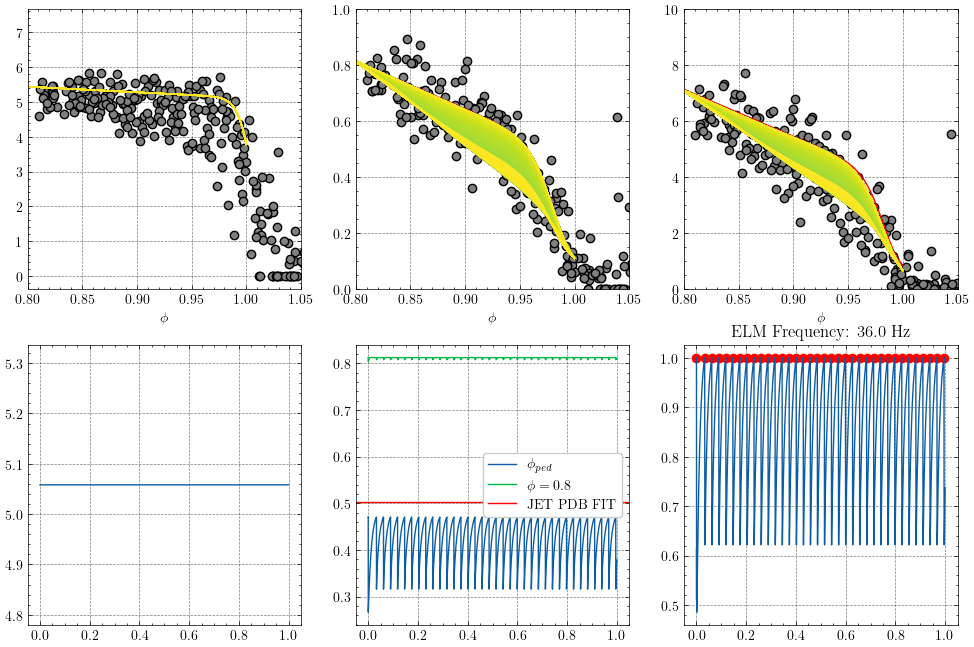

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
if shot_num == 83624:
    offset = 0.04
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83625:
    offset = 0.035
else: 
    offset = 0.0

axs = axs.ravel()
axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

T_START, T_END = 0.6, 0.8
t_idx_start = np.argmin(np.abs(t_keep - T_START))
t_idx_end = np.argmin(np.abs(t_keep - T_END))

for t_idx in range(t_idx_start, t_idx_end):
    color = plt.cm.viridis((t_idx - t_idx_start) / (t_idx_end - t_idx_start))

    axs[2].plot(phi_norm, pressure_profiles_all[t_idx], color=color)
    axs[1].plot(phi_norm, temperature_profiles_all[t_idx], color=color)
    axs[0].plot(phi_norm, density_profiles_all[t_idx], color=color)

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1)
axs[2].set_ylim(0, 10)

axs[3].plot(t_keep, density_profiles_all[:, nped_idx])

axs[4].plot(t_keep, temperature_profiles_all[:, tped_idx], label=r'$\phi_{ped}$')
axs[4].plot(t_keep, temperature_profiles_all[:, 0], label=r'$\phi = 0.8$')
axs[4].axhline(te_fit_params.h1, color='red', label='JET PDB FIT')
# axs[1].axhline(te_fit_params.h1, color='red', label='JET PDB FIT')
axs[5].plot(t_keep, alpha_crits / ALPHA_CRIT)
axs[5].scatter(t_keep[peaks], alpha_crits[peaks] / ALPHA_CRIT, color='red', label='ELM Peaks')
axs[5].set_title(f'ELM Frequency: {elm_freqs:.4} Hz')


axs[4].legend()
for ax in axs[:3]: 
    ax.set_xlim(0.8, 1.05)
    ax.set_xlabel(r'$\phi$')
    # ax.axvline(te_fit_params.p - te_fit_params.w / 2.0, color='red', linestyle='--')


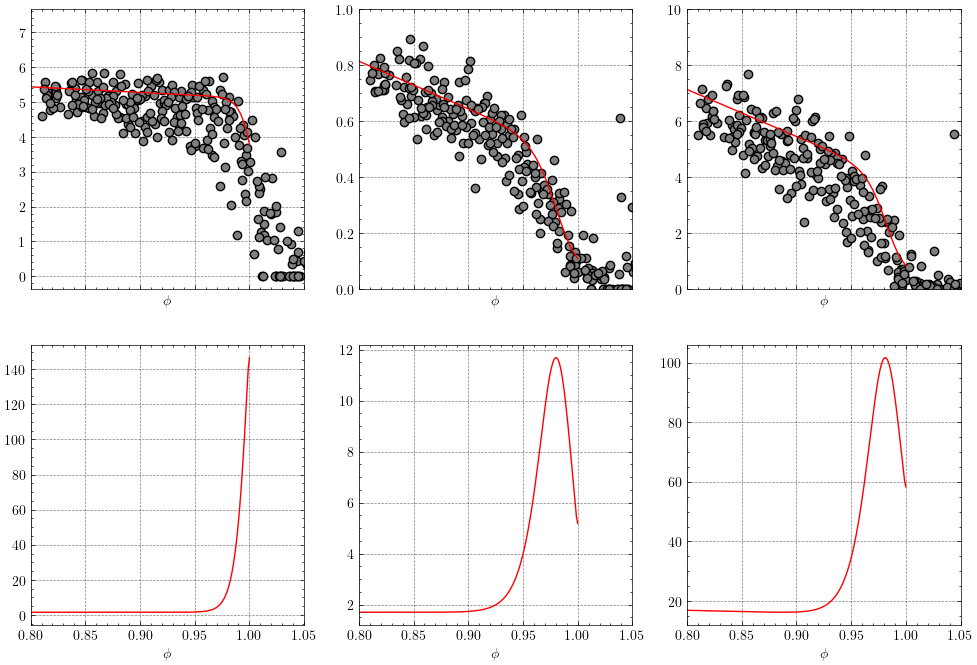

In [18]:
""" Plotting of crash """
if shot_num == 83624:
    offset = 0.04
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83625:
    offset = 0.035
else: 
    offset = 0.0

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs = axs.ravel()

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1)
axs[2].set_ylim(0, 10)

for ax in axs: 
    ax.set_xlim(0.8, 1.05)
    ax.set_xlabel(r'$\phi$')


axs[3].plot(phi_norm, abs(np.gradient(steady_state_ne, phi_norm)), color='red')
axs[4].plot(phi_norm, abs(np.gradient(steady_state_te, phi_norm)), color='red')
axs[5].plot(phi_norm, abs(np.gradient(steady_state_pe_from_me, phi_norm)), color='red')
